# Estimation of recurrence probabilities

### Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
home_directory = os.path.expanduser( '~' )
os.chdir(home_directory + '/DS_Project/modules')
os.getcwd()

'/pfs/data5/home/tu/tu_tu/tu_zxmny46/DS_Project/modules'

In [4]:
import pickle
import yaml
config_path = 'config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
from data_retrieval.DWD.DWDScraper import DWDScraper

### Data import

In [6]:
# get identified heatwave dates
with open(config['data']['dwd'] + '/heatwaves.pkl', "rb") as input_file:
    heat = pickle.load(input_file)
print(heat)

[datetime.date(2022, 6, 18), datetime.date(2022, 6, 19), datetime.date(2022, 6, 20), datetime.date(2022, 6, 21), datetime.date(2022, 7, 18), datetime.date(2022, 7, 19), datetime.date(2022, 7, 20), datetime.date(2022, 8, 3), datetime.date(2022, 8, 4), datetime.date(2022, 8, 5)]


In [7]:
def divide_dates_into_sublists(dates):
    sublists = []
    sublist = [dates[0]]  # Start a new sublist with the first date
    
    for i in range(1, len(dates)):
        current_date = dates[i]
        previous_date = dates[i - 1]
        
        if (current_date - previous_date) > timedelta(days=1):
            sublists.append(sublist)
            sublist = []
        sublist.append(current_date)
    
    sublists.append(sublist)
    
    return sublists

In [8]:
sublists = divide_dates_into_sublists(heat)
print(sublists)

[[datetime.date(2022, 6, 18), datetime.date(2022, 6, 19), datetime.date(2022, 6, 20), datetime.date(2022, 6, 21)], [datetime.date(2022, 7, 18), datetime.date(2022, 7, 19), datetime.date(2022, 7, 20)], [datetime.date(2022, 8, 3), datetime.date(2022, 8, 4), datetime.date(2022, 8, 5)]]


In [9]:
# scrape data for Munich city station from 2014 to 2022
S = DWDScraper()
S.scrape("munich-city.csv", "2014-01-01","2022-12-31", [3379])

In [10]:
# get scraped data
munich_city = pd.read_csv(config['data']['dwd']+'/munich-city.csv')
munich_city['MESS_DATUM'] = pd.to_datetime(munich_city['MESS_DATUM'], format='%Y-%m-%d %H')
munich_city['DATE'] = munich_city['MESS_DATUM'].dt.date

In [11]:
# get daily maximum temperatures (for June, July, August)
years = list(range(2014, 2023))
months = [6,7,8]
sub_index = (munich_city['MESS_DATUM'].dt.year.isin(years)) & (munich_city['MESS_DATUM'].dt.month.isin(months))
tseries = munich_city[sub_index].groupby([munich_city['DATE']]).max()['TT_TU']
tseries.index = pd.to_datetime(tseries.index)

### Descriptives

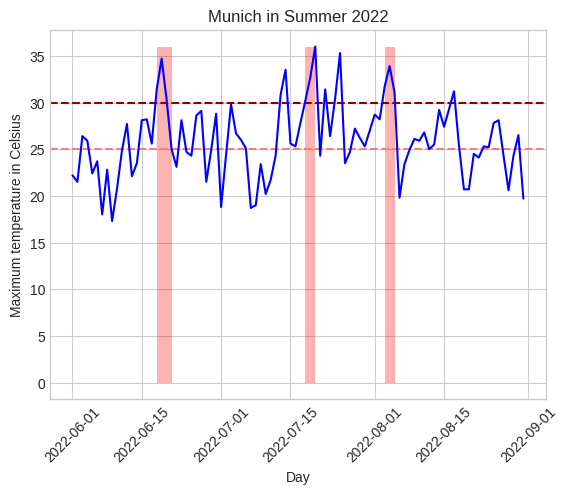

In [13]:
# plot Munich 2022 data including heatwaves marker
y2022_index = tseries.index.year.isin([2022])
time_series = tseries[y2022_index]
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots()

ax.axhline(30, color='darkred', linestyle='--')
ax.axhline(25, color='lightcoral', linestyle='--')

ax.plot(time_series.index, time_series.values, color='blue')
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))

for sublist in sublists:
    alpha = 0.3
    
    start_date = sublist[0]
    end_date = sublist[-1]
    
    start_idx = time_series.index.get_loc(start_date.strftime("%Y-%m-%d"))
    end_idx = time_series.index.get_loc(end_date.strftime("%Y-%m-%d"))

    ax.fill_between(time_series.index[start_idx:end_idx+1], 0, time_series.values.max(), facecolor='red', alpha=alpha)

ax.set_xlabel('Day')
plt.xticks(rotation=45)
ax.set_ylabel('Maximum temperature in Celsius')
ax.set_title('Munich in Summer 2022')

plt.savefig(config['data']['dwd'] + '/summer_munich_2022.png', bbox_inches="tight")

plt.show()

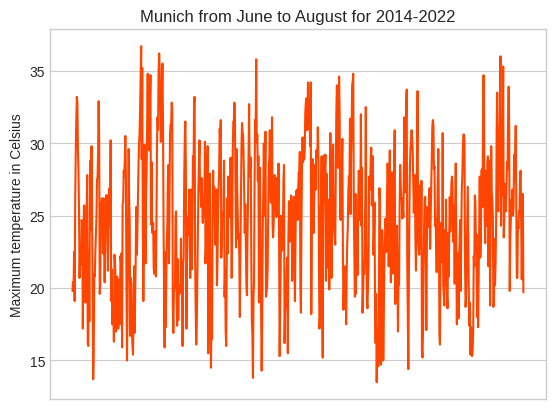

In [14]:
# plot full time series data
tseries.reset_index(drop=True).plot(color='orangered')
plt.xticks([], [])
plt.ylabel('Maximum temperature in Celsius')
plt.title('Munich from June to August for 2014-2022')
plt.show()

### Modeling ARMA(1)

In [15]:
# dickey fuller test
dickeyfuller = stattools.adfuller(
    tseries,
    autolag="AIC"
)

print('ADF Statistic: %f' % dickeyfuller[0])

print('p-value: %f' % dickeyfuller[1])

print('Critical Values:')

for key, value in dickeyfuller[4].items():
    print('\t%s: %.3f' % (key, value))
if dickeyfuller[0] > dickeyfuller[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Stationary")

ADF Statistic: -13.162753
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Failed to Reject Ho - Time Series is Stationary


In [16]:
arma_mod = ARIMA(tseries.reset_index(drop=True), order=(1,0,1)).fit()
print(arma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                  TT_TU   No. Observations:                  828
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2242.363
Date:                Mon, 19 Jun 2023   AIC                           4492.725
Time:                        20:12:43   BIC                           4511.601
Sample:                             0   HQIC                          4499.965
                                - 828                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.7237      0.361     68.558      0.000      24.017      25.430
ar.L1          0.5642      0.045     12.424      0.000       0.475       0.653
ma.L1          0.1119      0.054      2.060      0.0

In [17]:
# extract model parameters
ar = arma_mod.arparams
ma = arma_mod.maparams
ar = np.r_[1, -ar]
ma = np.r_[1, ma]

### Simulating data

In [18]:
# standardize data
m = tseries.mean()
sd = tseries.std()
standard = (tseries - m) / sd

In [19]:
# simulate data for one year (specified number of months only)
r = 10000
n = sum(y2022_index)
mat = np.empty([r,n])
for i in range(r):
    mat[i,:] = arma_generate_sample(ar, ma, nsample=n)

In [20]:
# compare to real world data
result = np.empty([r,n])
for i in range(r):
    result[i,:] = np.reshape(np.where(standard[y2022_index] > mat[i,:],1,0),[n,])
means = result.mean(axis=0)

### Compare to identified heatwaves

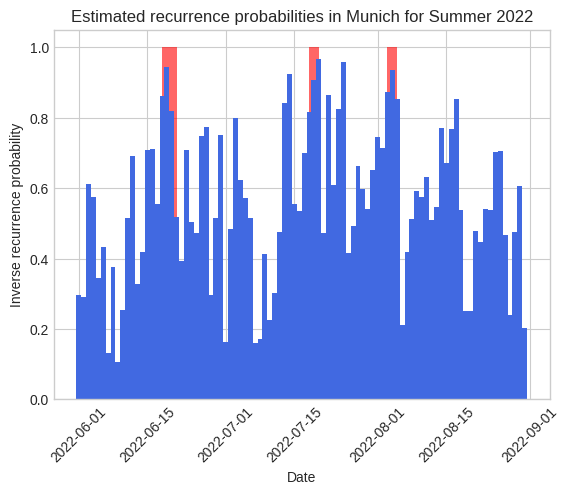

In [21]:
fig, ax = plt.subplots()
for sublist in sublists:
    alpha = 0.6
    start_date = sublist[0]
    end_date = sublist[-1]
    start_idx = time_series.index.get_loc(start_date.strftime("%Y-%m-%d"))
    end_idx = time_series.index.get_loc(end_date.strftime("%Y-%m-%d"))
    ax.fill_between(time_series.index[start_idx:end_idx+1], 0, 1, facecolor='red', alpha=alpha)
ax.bar(time_series.index, pd.Series(means).values, color='royalblue', width=1)
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.set_xlabel('Date')
plt.xticks(rotation=45)
ax.set_ylabel('Inverse recurrence probability')
ax.set_title('Estimated recurrence probabilities in Munich for Summer 2022')
plt.show()

In [22]:
heat_index = [i in heat for i in pd.to_datetime(tseries[y2022_index].index).to_series().dt.date]
recurrence_prob = pd.Series(means[heat_index], index=heat)
print(recurrence_prob)

2022-06-18    0.8610
2022-06-19    0.9450
2022-06-20    0.8197
2022-06-21    0.5190
2022-07-18    0.8175
2022-07-19    0.9064
2022-07-20    0.9673
2022-08-03    0.8738
2022-08-04    0.9342
2022-08-05    0.8540
dtype: float64
